# Artificial Neural Networks and Deep Learning

---

## Homework 2: Semantic Segmentation
This notebook contains one possible structure for the second homework of the AN2DL course. The goal is to perform semantic segmentation on a specific set of images, collected from Mars surface.

## TODO:
* Analizzare il test set
* La classe di Background (label = 0) non è inclusa nella valutazione del MeanIoU e pertanto è da escludersi.

* Da questo video (https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) si nota che viene anche usato un layer di dropout con rate piccolo (0.1) durante la convoluzione: può aiutare?

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ['PYTHONHASHSEED'] = str(seed)
#os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

seed = 42
# np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
# Load the entire dataset
data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👀 Inspect the dataset
Dataset inspection is meant to find possible outliers in the images, detect duplicates and, more in general, to do everything connected to data cleaning and pre-processing.

[1616 2220 1359  735 2578 1449  840 1073 2267 1708]


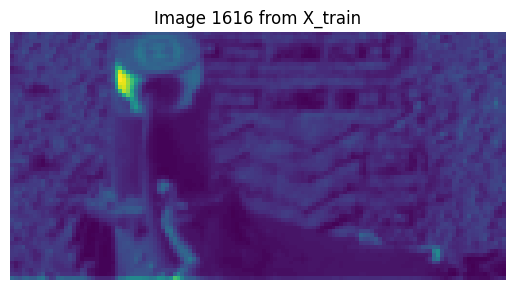

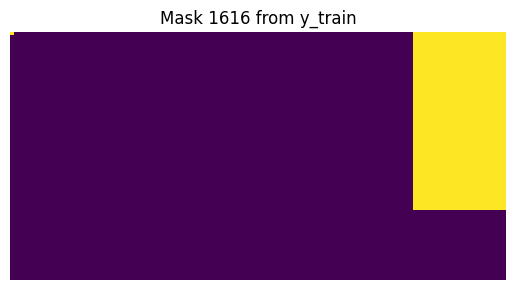

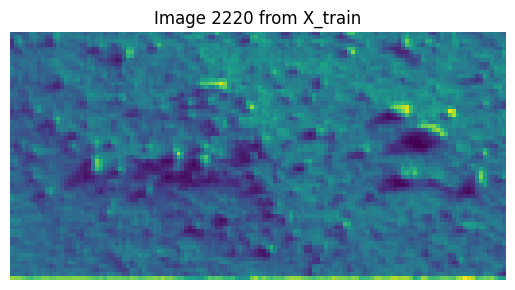

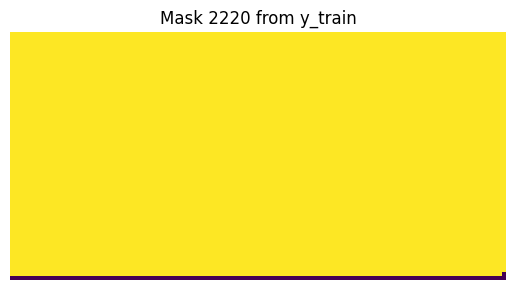

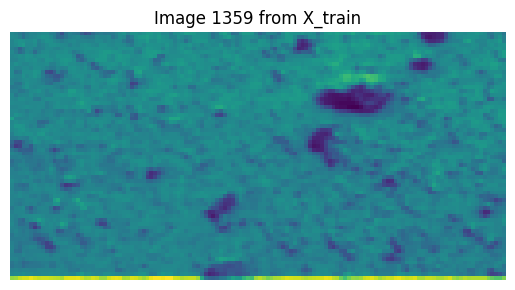

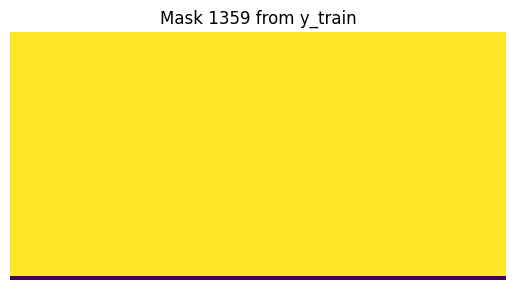

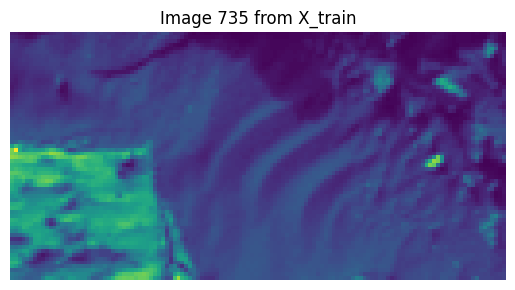

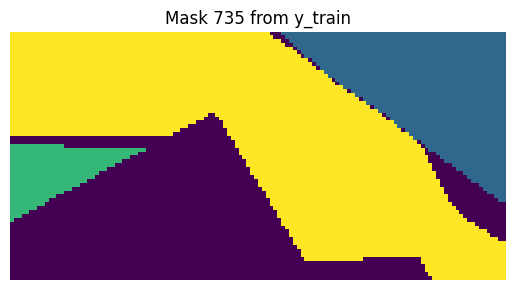

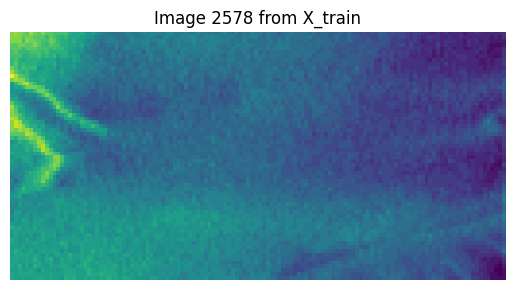

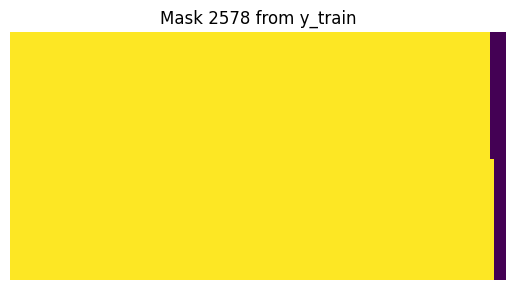

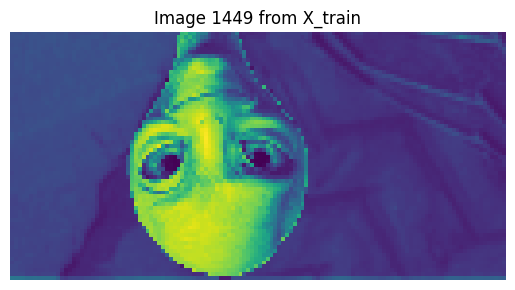

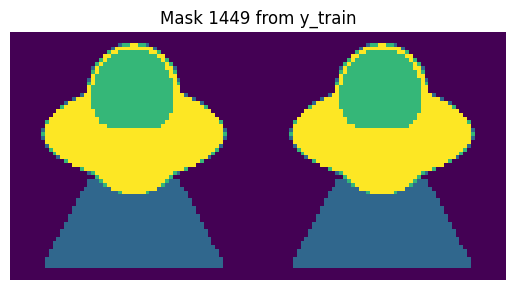

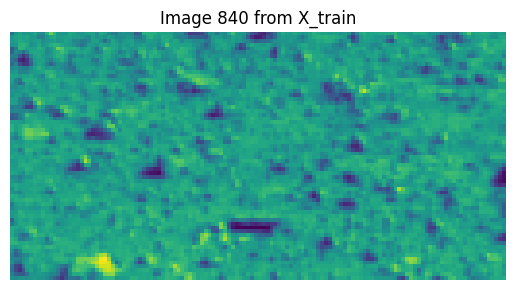

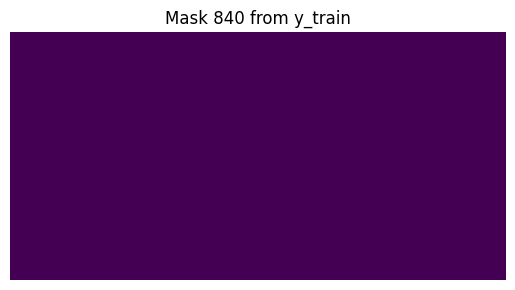

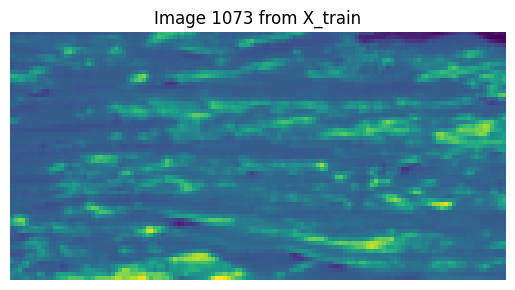

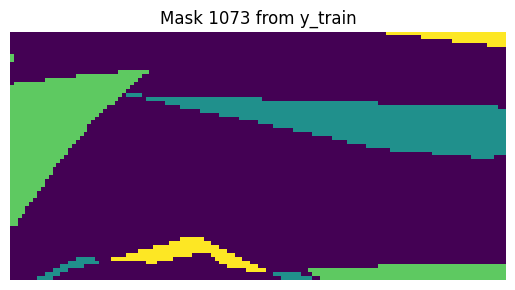

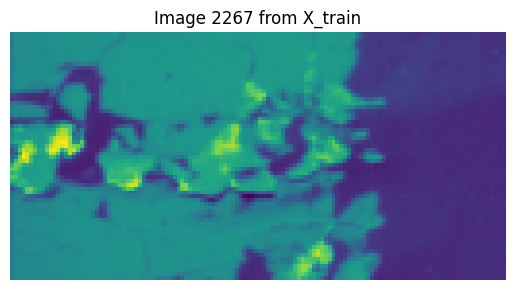

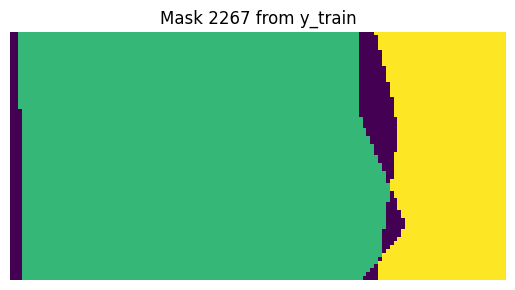

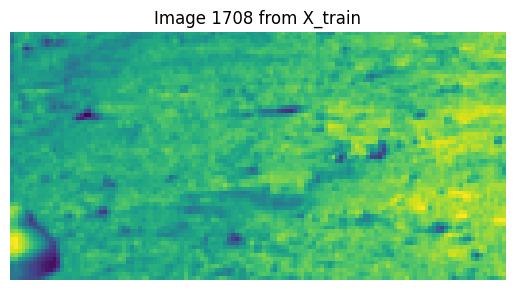

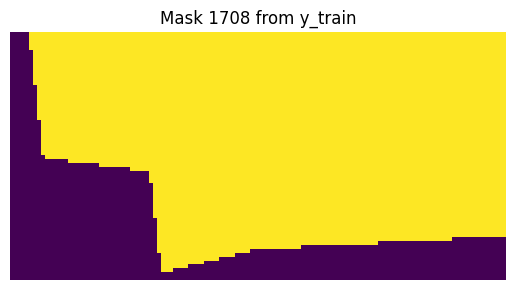

In [3]:
# Create a random index to display every time a different set of images
X_train_size = X_train.shape[0]
random_indices = np.random.randint(0, X_train_size, size = 10)
print(random_indices)

# Plot the image
for index in random_indices:
    plt.imshow(X_train[index])
    plt.title(f"Image {index} from X_train")
    plt.axis('off')
    plt.show()
    
    plt.imshow(y_train[index])
    plt.title(f"Mask {index} from y_train")
    plt.axis('off')
    plt.show()

### 🧹 Remove the Outliers
Analysing the *X_train* and *y_train* sets, it is possible to notice some outliers. For example, there are some pictures (e.g. the one with index 62) contains the picture of an alien. 

By understanding both the pictures and the masks, the masks seems to be the same even if the alien picture is flipped. So we can scan all the masks that are the same of picture 62 and then remove them from the dataset.

In [4]:
# This function establish if image1 and image2 are the same images, pixel-wise.
def are_same_mask (image1, image2):
    if image1.shape != image2.shape:
        print("[ERROR] The images are not the same size.")
        return False
    return np.array_equal(image1, image2)

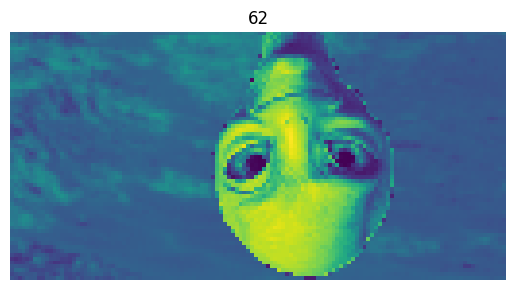

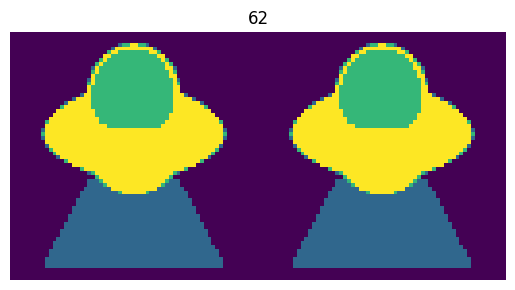

In [5]:
# Show the first picture of an alien
first_alien_index = 62
alien_indices = []
alien_indices.append(first_alien_index)

plt.imshow(X_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

plt.imshow(y_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

In [6]:
# Detect all the images with the same masks as of the first alien
for i in range(X_train_size):
    if i != first_alien_index and are_same_mask(y_train[first_alien_index], y_train[i]):
        alien_indices.append(i)

print(f"{len(alien_indices)} images have the same mask of the first alien picture:")
print(alien_indices)

110 images have the same mask of the first alien picture:
[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


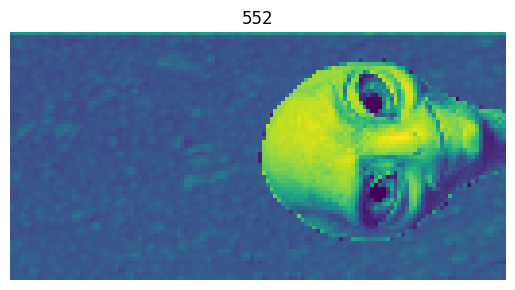

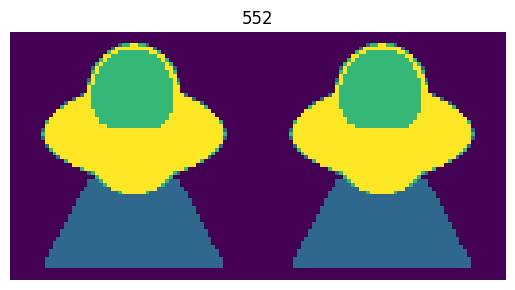

In [7]:
# Display one random image containing an alien
random_alien = alien_indices[np.random.randint(0, len(alien_indices))]

plt.imshow(X_train[random_alien])
plt.title(random_alien)
plt.axis('off')
plt.show()

plt.imshow(y_train[random_alien])
plt.title(random_alien)
plt.axis('off')
plt.show()

In [8]:
# Delete from X_train and y_train all the images with index in alien_indices
X_train = np.delete(X_train, alien_indices, axis=0)
y_train = np.delete(y_train, alien_indices, axis=0)

print("Shape of X_train without aliens: ", X_train.shape)
print("Shape of y_train without aliens: ", y_train.shape)

Shape of X_train without aliens:  (2505, 64, 128)
Shape of y_train without aliens:  (2505, 64, 128)


## 🪓 Split into training and validation set
The training set provided via the arrays *X_train* and *y_train* should be splitted into a new effective training set and a validation set.

In [9]:
# Split into training and validation set with a 80/20 ratio.
X_train, X_val, y_train, y_val = train_test_split (
    X_train, y_train, test_size = 0.20, random_state = seed
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2004, 64, 128)
y_train shape:  (2004, 64, 128)
X_val shape:  (501, 64, 128)
y_val shape:  (501, 64, 128)


In [10]:
# Define the classes 
classes = {0: "Background", 1: "Soil", 2: "Bedrock", 3: "Sand", 4: "Big Rock"}

In [11]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Models and Experiments
A first experiment of the model is done by building from scratch the U-Net architecture.

In [12]:
# Define network hyperparameters
batch_size = 32
learning_rate = 1e-4
epochs = 100

print("Batch size: ", batch_size)
print("Learning rate: ", learning_rate)
print("Epochs: ", epochs)

Batch size:  32
Learning rate:  0.0001
Epochs:  200


In [13]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1),
                       bias_regularizer=regularizers.L2(1e-4), kernel_regularizer=regularizers.L2(1e-5))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [14]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 512, name='bottleneck')

    # Upsampling path
    u3 = tfkl.UpSampling2D()(bottleneck)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 256, name='up_block3_')
    
    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

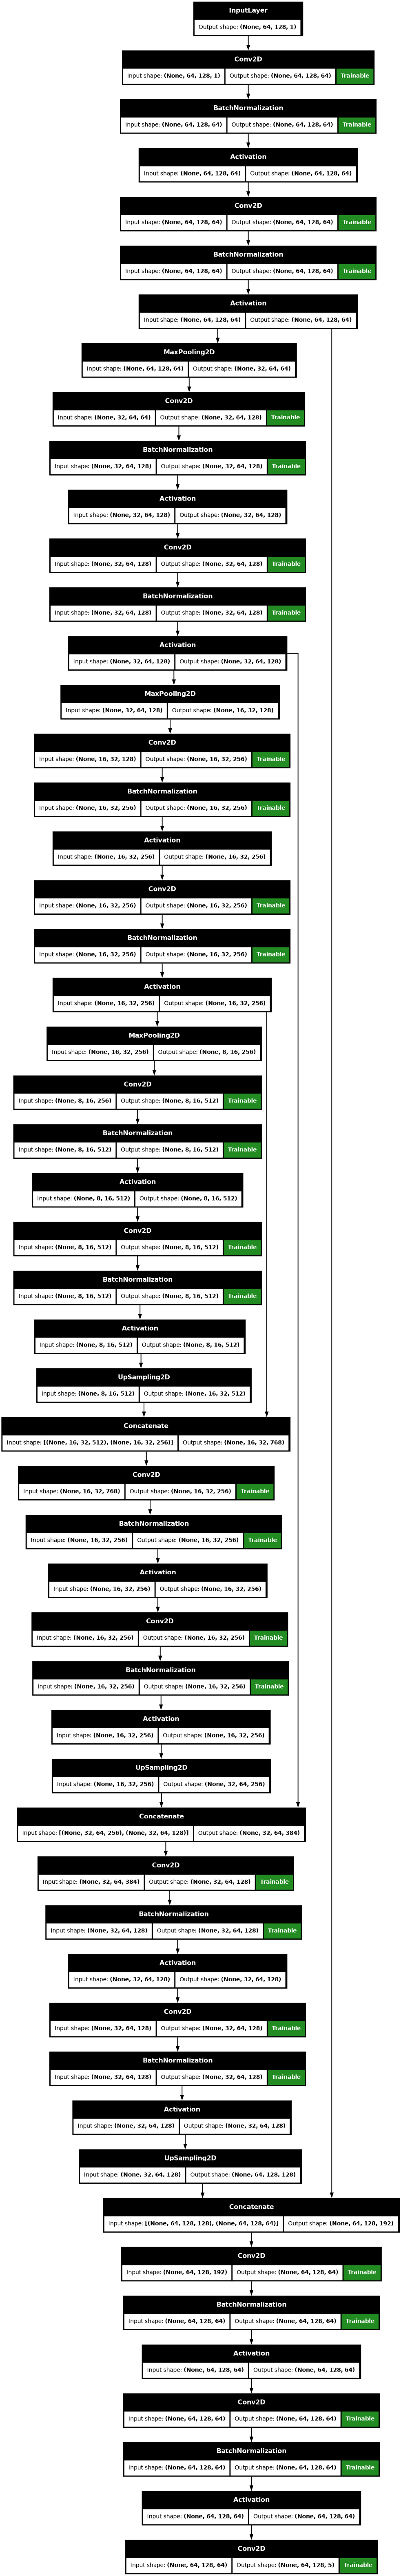

In [15]:
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, show_shapes=True, dpi=70)

In [16]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [17]:
# Define custom Mean Intersection Over Union metric
# By default, no classes are excluded.
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_io_u", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [18]:
# Define the metric of mean intersection over union
# As suggested in the exercise session, a custom MeanIoU is suggested
# Class 0 (Background) is excluded from the computation of the MeanIoU, as reported in "Data" section
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])

In [19]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_image, original_mask, num_classes, frequency=5):
        super().__init__()
        self.original_image = original_image   # Define the original image
        self.original_mask = original_mask     # Define the original mask
        self.num_classes = num_classes         # Define the number of classes
        self.frequency = frequency             # Define the visualization frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = np.expand_dims(self.original_image, axis=0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)            
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.original_image)
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(apply_colormap(self.original_mask, colormap))
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()            

In [20]:
# Compile the model
print("Compiling model...")
model.compile (
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [21]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor='val_mean_io_u',
    mode='max',
    patience=30,
    restore_best_weights=True
)

random_viz = np.random.randint(0, X_val.shape[0])
print("Showing evolution on image", random_viz)
viz_callback = VizCallback(X_val[random_viz], y_val[random_viz], num_classes)

callbacks = [early_stopping, viz_callback]

Showing evolution on image 394


Epoch 1/200


I0000 00:00:1732969279.262260      94 service.cc:145] XLA service 0x7bb2f8002960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732969279.262362      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1732969282.781457      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/63 ━━━━━━━━━━━━━━━━━━━━ 27:14 26s/step - accuracy: 0.1826 - loss: 1.8723 - mean_io_u: 0.0822

I0000 00:00:1732969296.654139      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4220 - loss: 1.4575 - mean_io_u: 0.2080

W0000 00:00:1732969304.283497      95 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4235 - loss: 1.4547 - mean_io_u: 0.2089

W0000 00:00:1732969319.686129      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732969323.316215      96 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


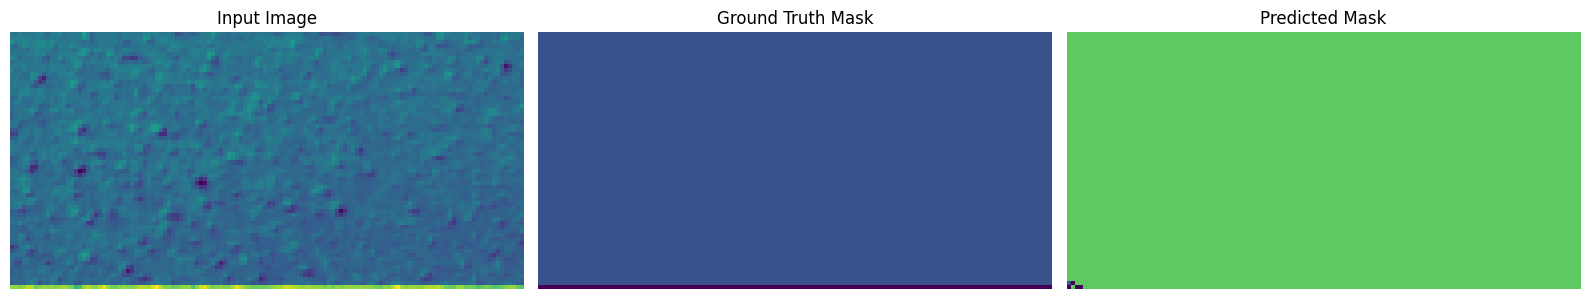

63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 506ms/step - accuracy: 0.4249 - loss: 1.4520 - mean_io_u: 0.2097 - val_accuracy: 0.1979 - val_loss: 1.8235 - val_mean_io_u: 0.0525
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6221 - loss: 1.0438 - mean_io_u: 0.3343 - val_accuracy: 0.1979 - val_loss: 2.4035 - val_mean_io_u: 0.0525
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6574 - loss: 0.9402 - mean_io_u: 0.3629 - val_accuracy: 0.1979 - val_loss: 3.0065 - val_mean_io_u: 0.0525
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6742 - loss: 0.8880 - mean_io_u: 0.3747 - val_accuracy: 0.1979 - val_loss: 4.6407 - val_mean_io_u: 0.0656
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.6869 - loss: 0.8475 - mean_io_u: 0.3852 - val_accuracy: 0.1979 - val_loss: 5.4393 - val_mean_io_u: 0.0525
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7025 - loss: 0.8092 - mean_io_u: 0.3965

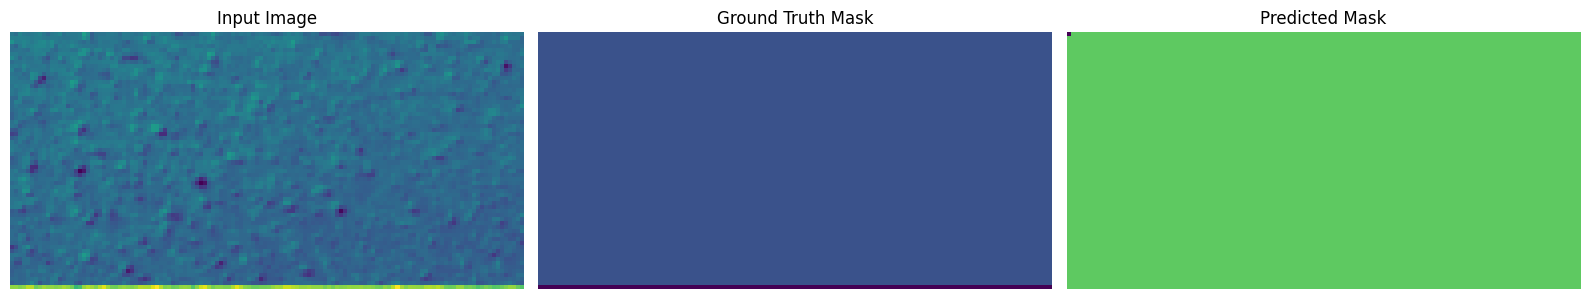

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7026 - loss: 0.8090 - mean_io_u: 0.3966 - val_accuracy: 0.1979 - val_loss: 6.3242 - val_mean_io_u: 0.0525
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7108 - loss: 0.7831 - mean_io_u: 0.4055 - val_accuracy: 0.2126 - val_loss: 4.7550 - val_mean_io_u: 0.0608
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7203 - loss: 0.7599 - mean_io_u: 0.4124 - val_accuracy: 0.2754 - val_loss: 3.5353 - val_mean_io_u: 0.1009
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7313 - loss: 0.7300 - mean_io_u: 0.4219 - val_accuracy: 0.4537 - val_loss: 1.9955 - val_mean_io_u: 0.2312
Epoch 10/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7426 - loss: 0.6978 - mean_io_u: 0.4311 - val_accuracy: 0.4772 - val_loss: 1.5918 - val_mean_io_u: 0.2151
Epoch 11/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7588 - loss: 0.6691 - mean_io_u: 0.4424

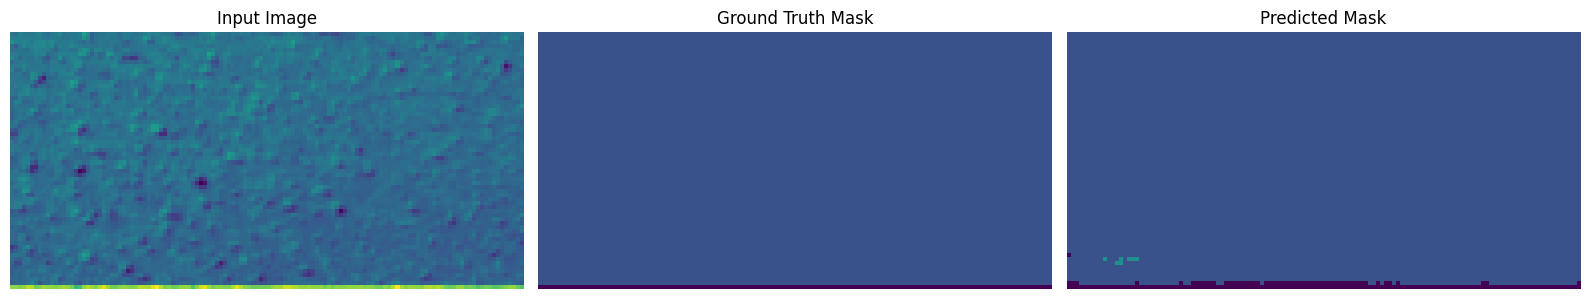

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7589 - loss: 0.6688 - mean_io_u: 0.4425 - val_accuracy: 0.5804 - val_loss: 1.1685 - val_mean_io_u: 0.3021
Epoch 12/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7636 - loss: 0.6396 - mean_io_u: 0.4425 - val_accuracy: 0.5881 - val_loss: 1.1709 - val_mean_io_u: 0.3052
Epoch 13/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7730 - loss: 0.6239 - mean_io_u: 0.4498 - val_accuracy: 0.5824 - val_loss: 1.2839 - val_mean_io_u: 0.3138
Epoch 14/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.7836 - loss: 0.6015 - mean_io_u: 0.4588 - val_accuracy: 0.5789 - val_loss: 1.3954 - val_mean_io_u: 0.2892
Epoch 15/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7911 - loss: 0.5842 - mean_io_u: 0.4661 - val_accuracy: 0.5159 - val_loss: 1.8971 - val_mean_io_u: 0.2281
Epoch 16/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7959 - loss: 0.5700 - mean_io_u: 0.4694

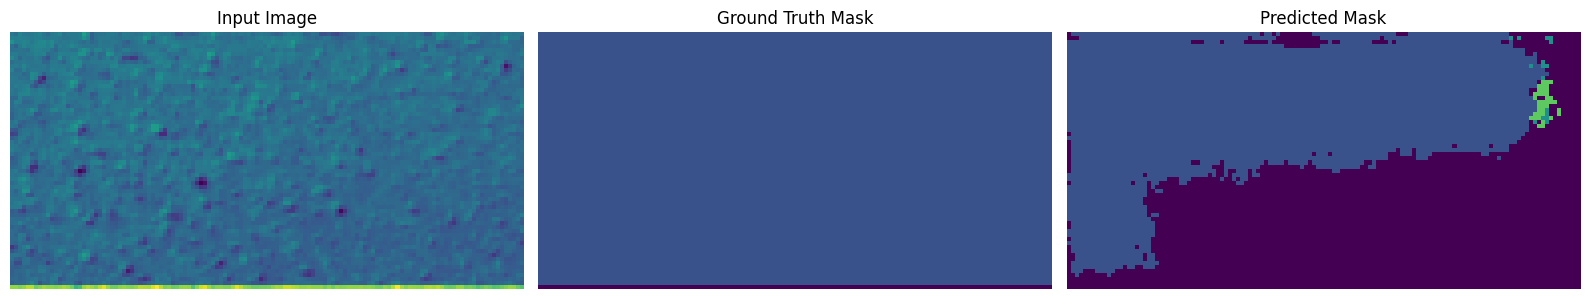

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7962 - loss: 0.5693 - mean_io_u: 0.4696 - val_accuracy: 0.4672 - val_loss: 2.1500 - val_mean_io_u: 0.1721
Epoch 17/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8064 - loss: 0.5443 - mean_io_u: 0.4803 - val_accuracy: 0.5602 - val_loss: 1.6409 - val_mean_io_u: 0.2807
Epoch 18/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8200 - loss: 0.5131 - mean_io_u: 0.4848 - val_accuracy: 0.6312 - val_loss: 1.3130 - val_mean_io_u: 0.3572
Epoch 19/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8358 - loss: 0.4765 - mean_io_u: 0.4949 - val_accuracy: 0.5562 - val_loss: 1.4646 - val_mean_io_u: 0.2679
Epoch 20/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8409 - loss: 0.4592 - mean_io_u: 0.4974 - val_accuracy: 0.5023 - val_loss: 1.9407 - val_mean_io_u: 0.2239
Epoch 21/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8498 - loss: 0.4414 - mean_io_u: 0.5040

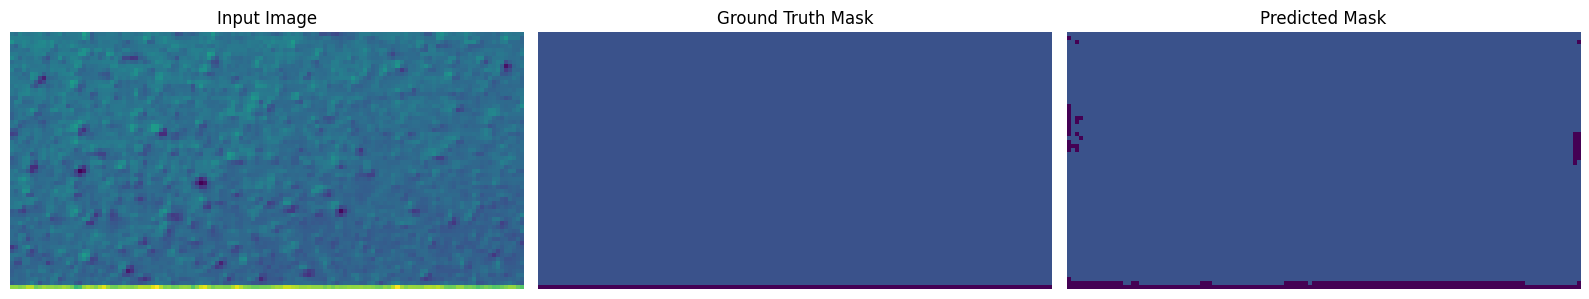

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8498 - loss: 0.4412 - mean_io_u: 0.5040 - val_accuracy: 0.5787 - val_loss: 1.6056 - val_mean_io_u: 0.2924
Epoch 22/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8446 - loss: 0.4506 - mean_io_u: 0.5026 - val_accuracy: 0.6471 - val_loss: 1.2658 - val_mean_io_u: 0.3321
Epoch 23/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8614 - loss: 0.4094 - mean_io_u: 0.5145 - val_accuracy: 0.5863 - val_loss: 1.5529 - val_mean_io_u: 0.2700
Epoch 24/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8656 - loss: 0.3956 - mean_io_u: 0.5123 - val_accuracy: 0.6487 - val_loss: 1.2040 - val_mean_io_u: 0.3406
Epoch 25/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8749 - loss: 0.3727 - mean_io_u: 0.5206 - val_accuracy: 0.6614 - val_loss: 1.1261 - val_mean_io_u: 0.3433
Epoch 26/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8858 - loss: 0.3430 - mean_io_u: 0.5305

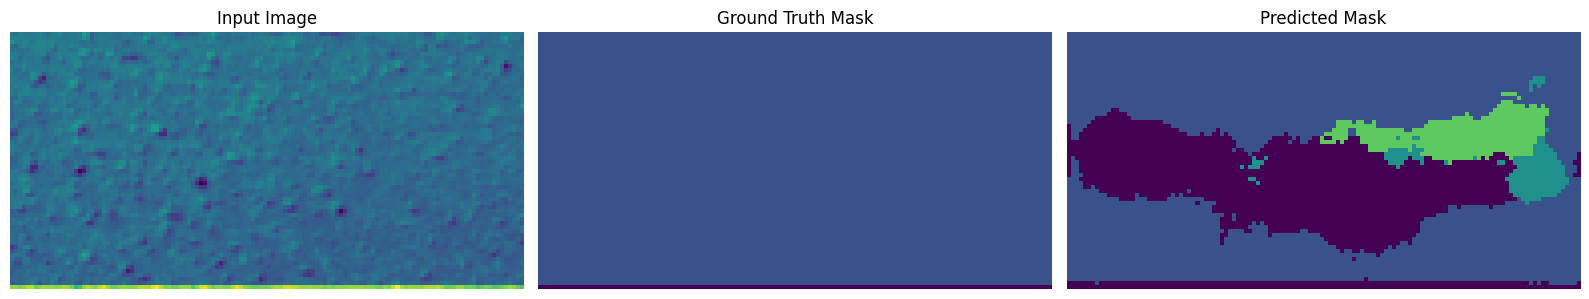

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8859 - loss: 0.3428 - mean_io_u: 0.5306 - val_accuracy: 0.6486 - val_loss: 1.2506 - val_mean_io_u: 0.3408
Epoch 27/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8978 - loss: 0.3099 - mean_io_u: 0.5392 - val_accuracy: 0.7099 - val_loss: 1.0910 - val_mean_io_u: 0.3877
Epoch 28/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9068 - loss: 0.2892 - mean_io_u: 0.5488 - val_accuracy: 0.6666 - val_loss: 1.3309 - val_mean_io_u: 0.3500
Epoch 29/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9114 - loss: 0.2770 - mean_io_u: 0.5534 - val_accuracy: 0.6656 - val_loss: 1.2842 - val_mean_io_u: 0.3608
Epoch 30/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9172 - loss: 0.2642 - mean_io_u: 0.5561 - val_accuracy: 0.7015 - val_loss: 1.0155 - val_mean_io_u: 0.3906
Epoch 31/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9212 - loss: 0.2505 - mean_io_u: 0.5573

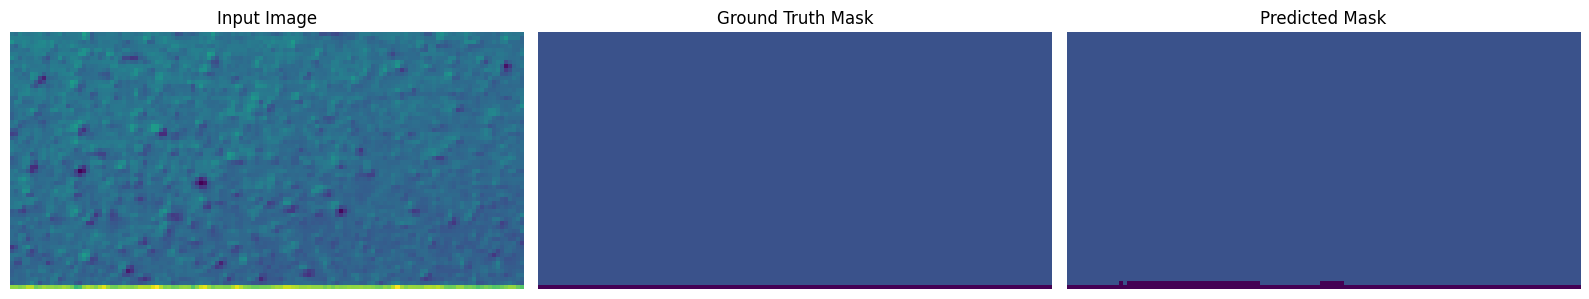

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9212 - loss: 0.2505 - mean_io_u: 0.5573 - val_accuracy: 0.6826 - val_loss: 1.1277 - val_mean_io_u: 0.3766
Epoch 32/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9252 - loss: 0.2400 - mean_io_u: 0.5617 - val_accuracy: 0.6346 - val_loss: 1.3578 - val_mean_io_u: 0.3203
Epoch 33/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9244 - loss: 0.2429 - mean_io_u: 0.5585 - val_accuracy: 0.6954 - val_loss: 1.0300 - val_mean_io_u: 0.3848
Epoch 34/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9253 - loss: 0.2407 - mean_io_u: 0.5561 - val_accuracy: 0.6268 - val_loss: 1.5451 - val_mean_io_u: 0.3007
Epoch 35/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9347 - loss: 0.2165 - mean_io_u: 0.5654 - val_accuracy: 0.6653 - val_loss: 1.2511 - val_mean_io_u: 0.3448
Epoch 36/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9268 - loss: 0.2333 - mean_io_u: 0.5548

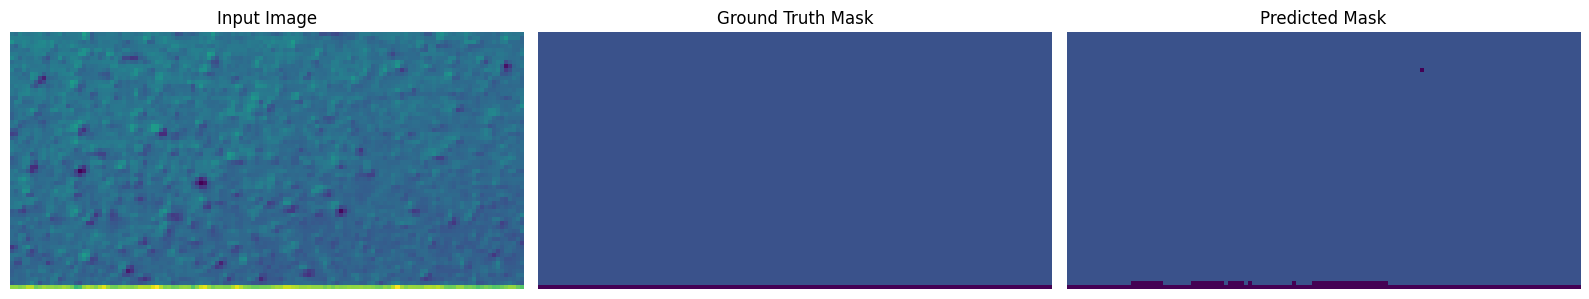

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9269 - loss: 0.2330 - mean_io_u: 0.5549 - val_accuracy: 0.6418 - val_loss: 1.2942 - val_mean_io_u: 0.3329
Epoch 37/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9392 - loss: 0.2040 - mean_io_u: 0.5679 - val_accuracy: 0.6380 - val_loss: 1.2133 - val_mean_io_u: 0.3209
Epoch 38/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9398 - loss: 0.1994 - mean_io_u: 0.5715 - val_accuracy: 0.6296 - val_loss: 1.3405 - val_mean_io_u: 0.3218
Epoch 39/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9435 - loss: 0.1894 - mean_io_u: 0.5701 - val_accuracy: 0.5624 - val_loss: 1.6727 - val_mean_io_u: 0.2702
Epoch 40/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9407 - loss: 0.1974 - mean_io_u: 0.5643 - val_accuracy: 0.6669 - val_loss: 1.2989 - val_mean_io_u: 0.3490
Epoch 41/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9432 - loss: 0.1884 - mean_io_u: 0.5675

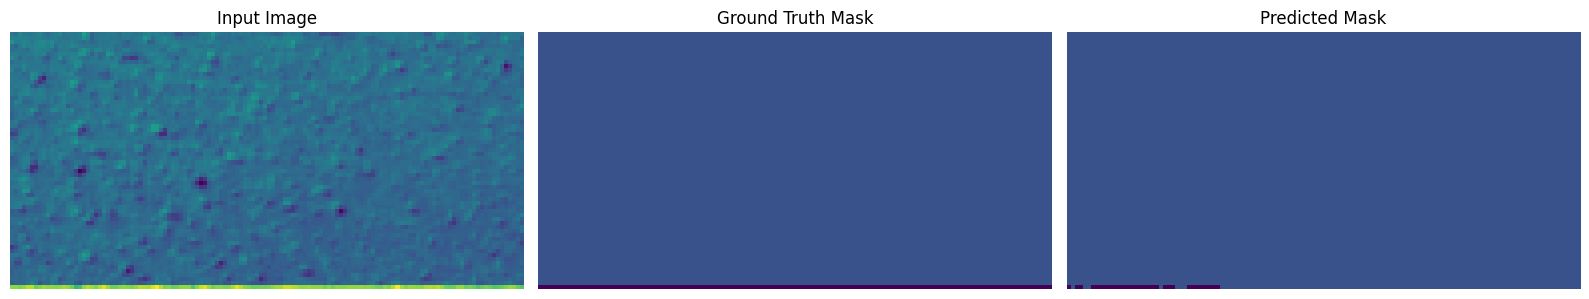

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9433 - loss: 0.1883 - mean_io_u: 0.5676 - val_accuracy: 0.6562 - val_loss: 1.5018 - val_mean_io_u: 0.3377
Epoch 42/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9497 - loss: 0.1735 - mean_io_u: 0.5741 - val_accuracy: 0.7246 - val_loss: 1.0616 - val_mean_io_u: 0.4114
Epoch 43/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9535 - loss: 0.1618 - mean_io_u: 0.5779 - val_accuracy: 0.6966 - val_loss: 1.1363 - val_mean_io_u: 0.3782
Epoch 44/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9595 - loss: 0.1473 - mean_io_u: 0.5863 - val_accuracy: 0.7171 - val_loss: 0.9993 - val_mean_io_u: 0.4070
Epoch 45/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9602 - loss: 0.1425 - mean_io_u: 0.5890 - val_accuracy: 0.6838 - val_loss: 1.1172 - val_mean_io_u: 0.3681
Epoch 46/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9596 - loss: 0.1445 - mean_io_u: 0.5866

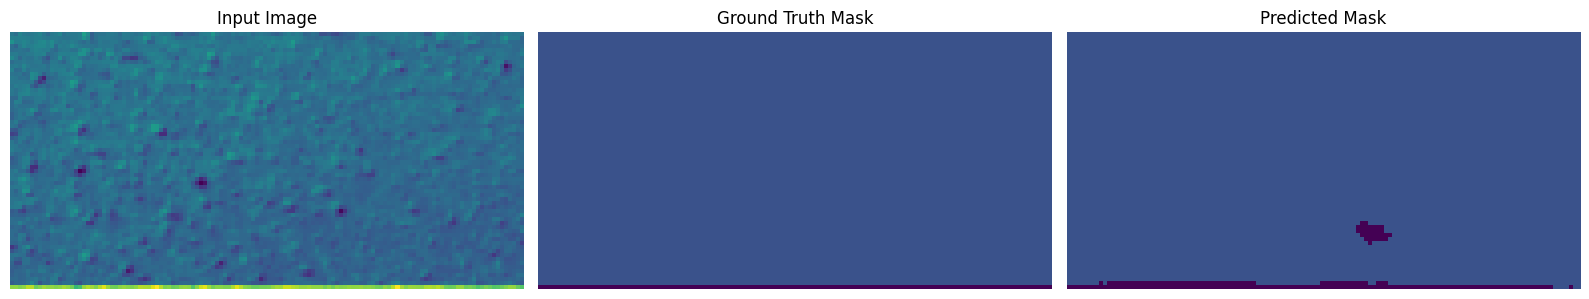

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9596 - loss: 0.1445 - mean_io_u: 0.5867 - val_accuracy: 0.6532 - val_loss: 1.2168 - val_mean_io_u: 0.3443
Epoch 47/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9570 - loss: 0.1501 - mean_io_u: 0.5900 - val_accuracy: 0.6859 - val_loss: 1.1719 - val_mean_io_u: 0.3790
Epoch 48/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9574 - loss: 0.1484 - mean_io_u: 0.5947 - val_accuracy: 0.7234 - val_loss: 1.1528 - val_mean_io_u: 0.4338
Epoch 49/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9560 - loss: 0.1523 - mean_io_u: 0.5886 - val_accuracy: 0.6739 - val_loss: 1.2967 - val_mean_io_u: 0.3784
Epoch 50/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9587 - loss: 0.1454 - mean_io_u: 0.6173 - val_accuracy: 0.7226 - val_loss: 1.1350 - val_mean_io_u: 0.4308
Epoch 51/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9547 - loss: 0.1558 - mean_io_u: 0.6109

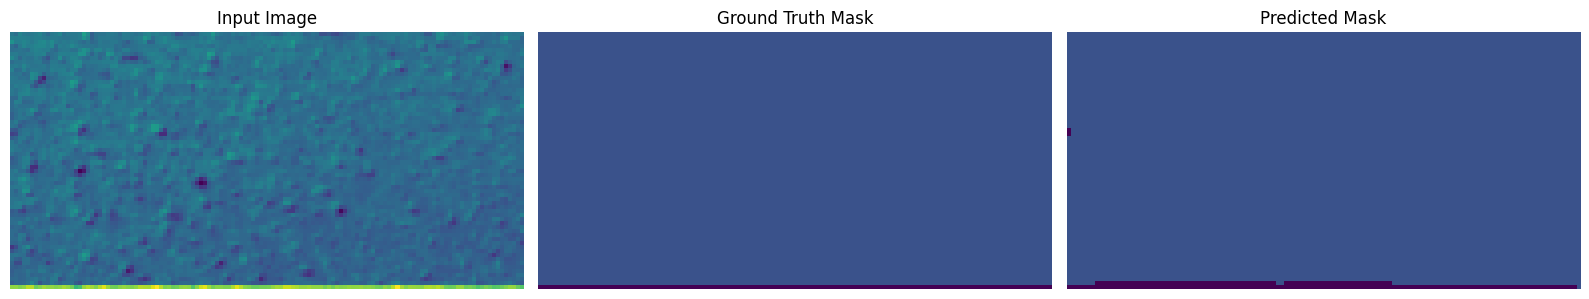

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9547 - loss: 0.1556 - mean_io_u: 0.6113 - val_accuracy: 0.6812 - val_loss: 1.2577 - val_mean_io_u: 0.3664
Epoch 52/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9656 - loss: 0.1262 - mean_io_u: 0.6339 - val_accuracy: 0.7011 - val_loss: 1.2424 - val_mean_io_u: 0.3897
Epoch 53/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9665 - loss: 0.1241 - mean_io_u: 0.6382 - val_accuracy: 0.6871 - val_loss: 1.3929 - val_mean_io_u: 0.3729
Epoch 54/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9652 - loss: 0.1258 - mean_io_u: 0.6454 - val_accuracy: 0.6808 - val_loss: 1.3172 - val_mean_io_u: 0.3717
Epoch 55/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9666 - loss: 0.1224 - mean_io_u: 0.6806 - val_accuracy: 0.6787 - val_loss: 1.3110 - val_mean_io_u: 0.3654
Epoch 56/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9681 - loss: 0.1176 - mean_io_u: 0.6815

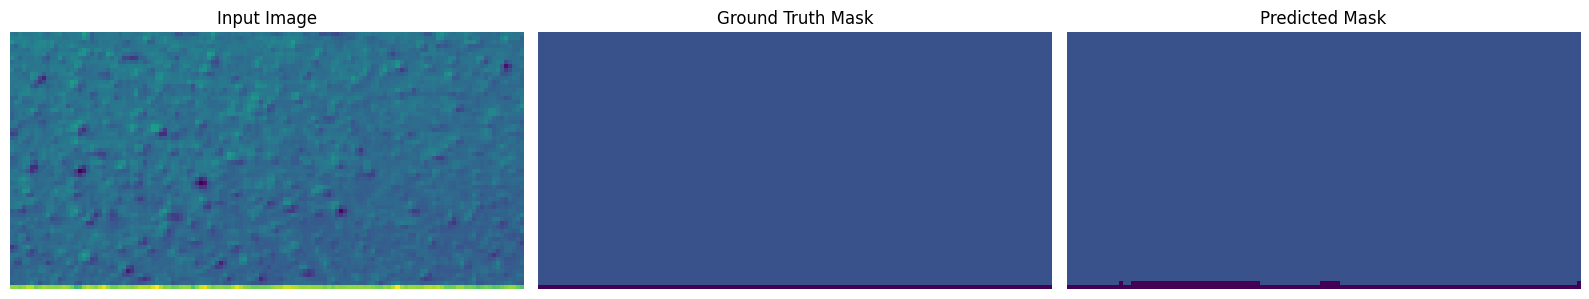

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9681 - loss: 0.1176 - mean_io_u: 0.6818 - val_accuracy: 0.6308 - val_loss: 1.5565 - val_mean_io_u: 0.3475
Epoch 57/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9710 - loss: 0.1105 - mean_io_u: 0.6898 - val_accuracy: 0.7243 - val_loss: 1.1106 - val_mean_io_u: 0.4333
Epoch 58/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9746 - loss: 0.1003 - mean_io_u: 0.6949 - val_accuracy: 0.7160 - val_loss: 1.1516 - val_mean_io_u: 0.4294
Epoch 59/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9751 - loss: 0.1007 - mean_io_u: 0.7030 - val_accuracy: 0.6671 - val_loss: 1.4600 - val_mean_io_u: 0.3450
Epoch 60/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9669 - loss: 0.1242 - mean_io_u: 0.6800 - val_accuracy: 0.6872 - val_loss: 1.3202 - val_mean_io_u: 0.4025
Epoch 61/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9727 - loss: 0.1042 - mean_io_u: 0.7091

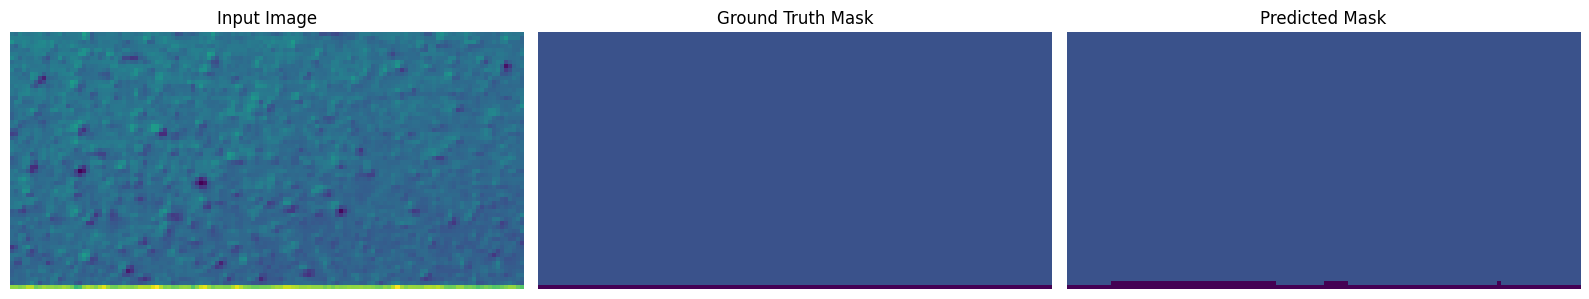

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9727 - loss: 0.1041 - mean_io_u: 0.7094 - val_accuracy: 0.7195 - val_loss: 1.1479 - val_mean_io_u: 0.4244
Epoch 62/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9737 - loss: 0.1017 - mean_io_u: 0.7060 - val_accuracy: 0.7390 - val_loss: 1.1661 - val_mean_io_u: 0.4519
Epoch 63/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9766 - loss: 0.0935 - mean_io_u: 0.7163 - val_accuracy: 0.7308 - val_loss: 1.1069 - val_mean_io_u: 0.4373
Epoch 64/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9771 - loss: 0.0924 - mean_io_u: 0.7222 - val_accuracy: 0.7311 - val_loss: 1.1677 - val_mean_io_u: 0.4453
Epoch 65/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9784 - loss: 0.0882 - mean_io_u: 0.7364 - val_accuracy: 0.6977 - val_loss: 1.2294 - val_mean_io_u: 0.4048
Epoch 66/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9775 - loss: 0.0908 - mean_io_u: 0.7322

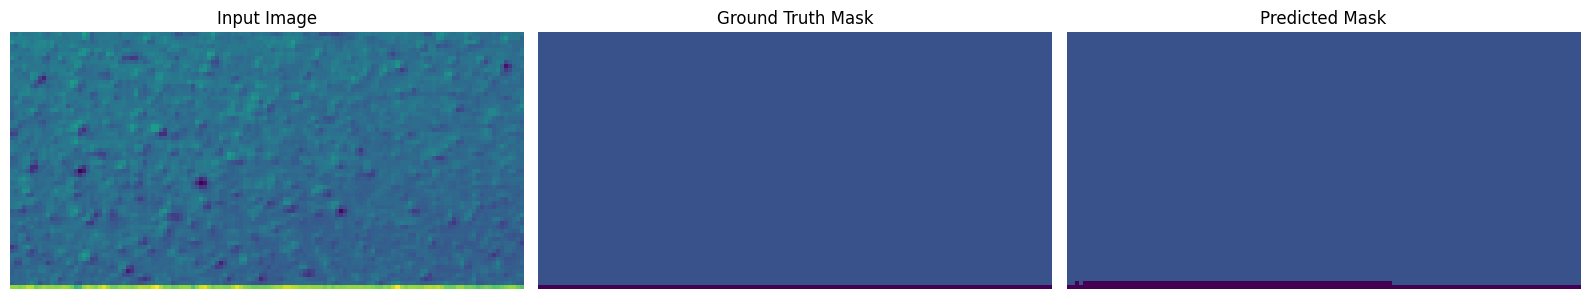

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9775 - loss: 0.0908 - mean_io_u: 0.7325 - val_accuracy: 0.7329 - val_loss: 1.1633 - val_mean_io_u: 0.4443
Epoch 67/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9757 - loss: 0.0964 - mean_io_u: 0.7349 - val_accuracy: 0.7070 - val_loss: 1.2154 - val_mean_io_u: 0.4068
Epoch 68/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9773 - loss: 0.0909 - mean_io_u: 0.7336 - val_accuracy: 0.7276 - val_loss: 1.2273 - val_mean_io_u: 0.4487
Epoch 69/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9793 - loss: 0.0853 - mean_io_u: 0.7476 - val_accuracy: 0.7233 - val_loss: 1.2159 - val_mean_io_u: 0.4253
Epoch 70/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9799 - loss: 0.0834 - mean_io_u: 0.7460 - val_accuracy: 0.6984 - val_loss: 1.4195 - val_mean_io_u: 0.4053
Epoch 71/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9792 - loss: 0.0847 - mean_io_u: 0.7407

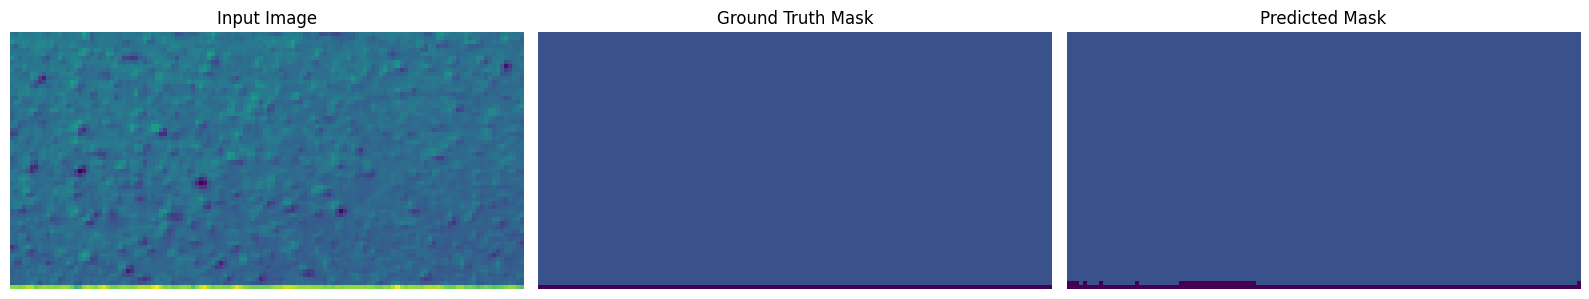

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9792 - loss: 0.0846 - mean_io_u: 0.7409 - val_accuracy: 0.7394 - val_loss: 1.1538 - val_mean_io_u: 0.4449
Epoch 72/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9763 - loss: 0.0936 - mean_io_u: 0.7527 - val_accuracy: 0.6292 - val_loss: 1.7263 - val_mean_io_u: 0.3183
Epoch 73/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.9519 - loss: 0.1681 - mean_io_u: 0.6900 - val_accuracy: 0.6885 - val_loss: 1.4781 - val_mean_io_u: 0.3802
Epoch 74/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9630 - loss: 0.1336 - mean_io_u: 0.7029 - val_accuracy: 0.7347 - val_loss: 1.1212 - val_mean_io_u: 0.4520
Epoch 75/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9767 - loss: 0.0934 - mean_io_u: 0.7425 - val_accuracy: 0.7178 - val_loss: 1.1970 - val_mean_io_u: 0.4097
Epoch 76/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9815 - loss: 0.0795 - mean_io_u: 0.7544

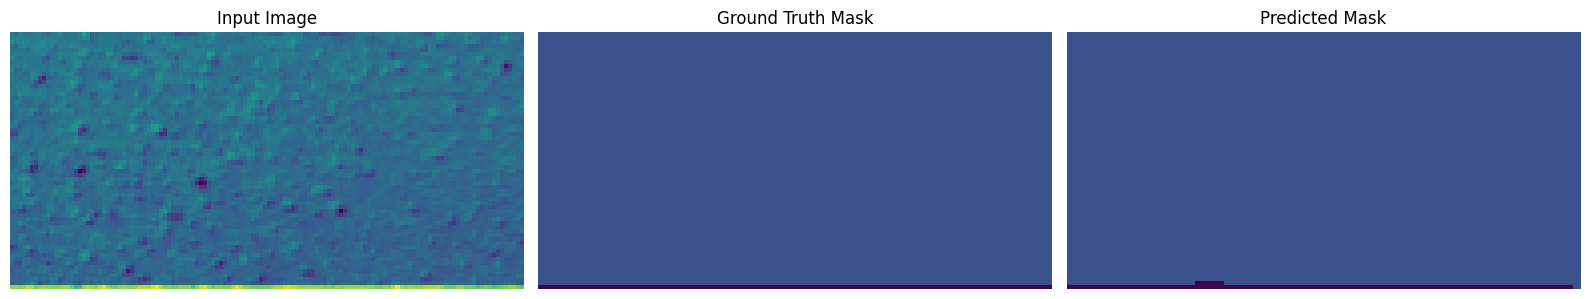

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9815 - loss: 0.0794 - mean_io_u: 0.7546 - val_accuracy: 0.7449 - val_loss: 1.0982 - val_mean_io_u: 0.4568
Epoch 77/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9848 - loss: 0.0705 - mean_io_u: 0.7488 - val_accuracy: 0.7319 - val_loss: 1.3069 - val_mean_io_u: 0.4553
Epoch 78/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9850 - loss: 0.0696 - mean_io_u: 0.7594 - val_accuracy: 0.7486 - val_loss: 1.1715 - val_mean_io_u: 0.4532
Epoch 79/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9849 - loss: 0.0692 - mean_io_u: 0.7660 - val_accuracy: 0.7293 - val_loss: 1.2216 - val_mean_io_u: 0.4324
Epoch 80/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9838 - loss: 0.0719 - mean_io_u: 0.7541 - val_accuracy: 0.7254 - val_loss: 1.2870 - val_mean_io_u: 0.4268
Epoch 81/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9825 - loss: 0.0755 - mean_io_u: 0.7597

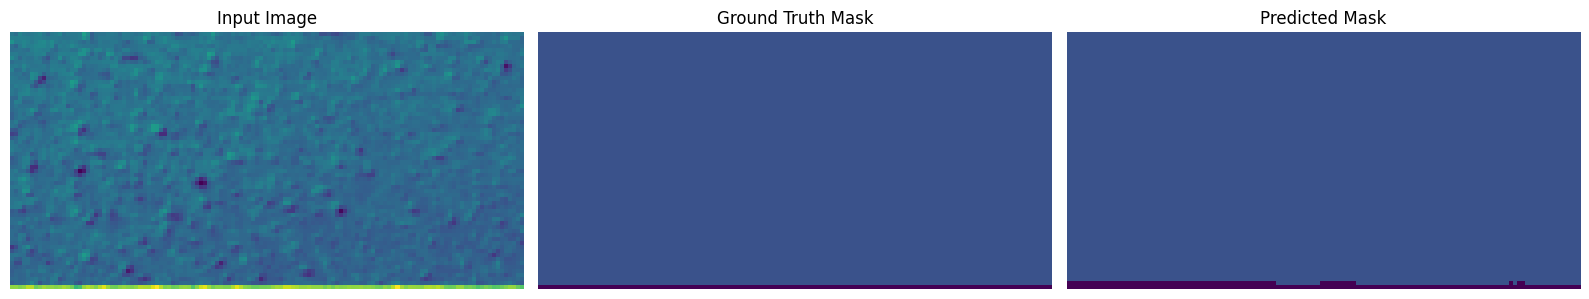

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9825 - loss: 0.0755 - mean_io_u: 0.7598 - val_accuracy: 0.7103 - val_loss: 1.4977 - val_mean_io_u: 0.4192
Epoch 82/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9829 - loss: 0.0747 - mean_io_u: 0.7576 - val_accuracy: 0.7321 - val_loss: 1.1995 - val_mean_io_u: 0.4346
Epoch 83/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9839 - loss: 0.0716 - mean_io_u: 0.7609 - val_accuracy: 0.7164 - val_loss: 1.3244 - val_mean_io_u: 0.4168
Epoch 84/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9841 - loss: 0.0715 - mean_io_u: 0.7614 - val_accuracy: 0.7187 - val_loss: 1.4541 - val_mean_io_u: 0.4148
Epoch 85/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9840 - loss: 0.0713 - mean_io_u: 0.7543 - val_accuracy: 0.6824 - val_loss: 1.7815 - val_mean_io_u: 0.3765
Epoch 86/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9823 - loss: 0.0756 - mean_io_u: 0.7492

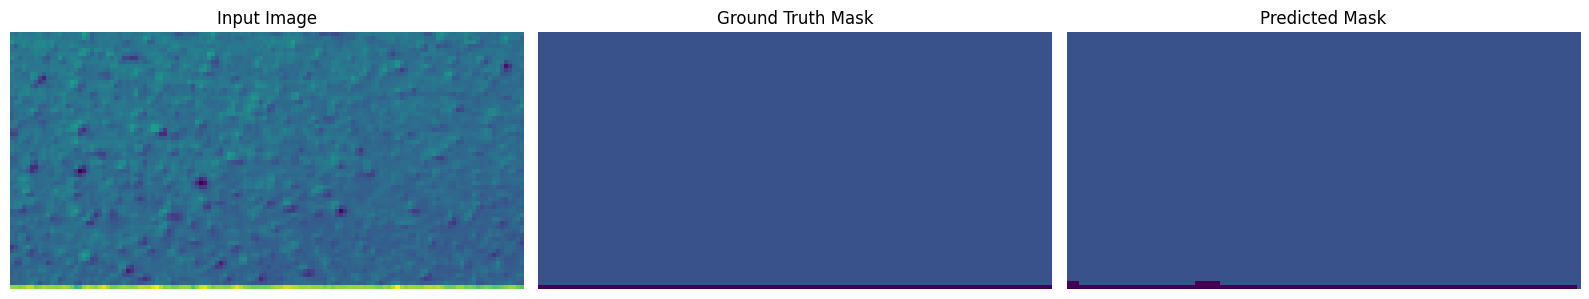

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9824 - loss: 0.0756 - mean_io_u: 0.7494 - val_accuracy: 0.7246 - val_loss: 1.2565 - val_mean_io_u: 0.4138
Epoch 87/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9833 - loss: 0.0733 - mean_io_u: 0.7583 - val_accuracy: 0.7419 - val_loss: 1.2724 - val_mean_io_u: 0.4478
Epoch 88/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9828 - loss: 0.0750 - mean_io_u: 0.7555 - val_accuracy: 0.6483 - val_loss: 1.9304 - val_mean_io_u: 0.3563
Epoch 89/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9793 - loss: 0.0842 - mean_io_u: 0.7446 - val_accuracy: 0.7279 - val_loss: 1.3583 - val_mean_io_u: 0.4306
Epoch 90/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9757 - loss: 0.0967 - mean_io_u: 0.7516 - val_accuracy: 0.6532 - val_loss: 2.4355 - val_mean_io_u: 0.3400
Epoch 91/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9233 - loss: 0.2438 - mean_io_u: 0.6365

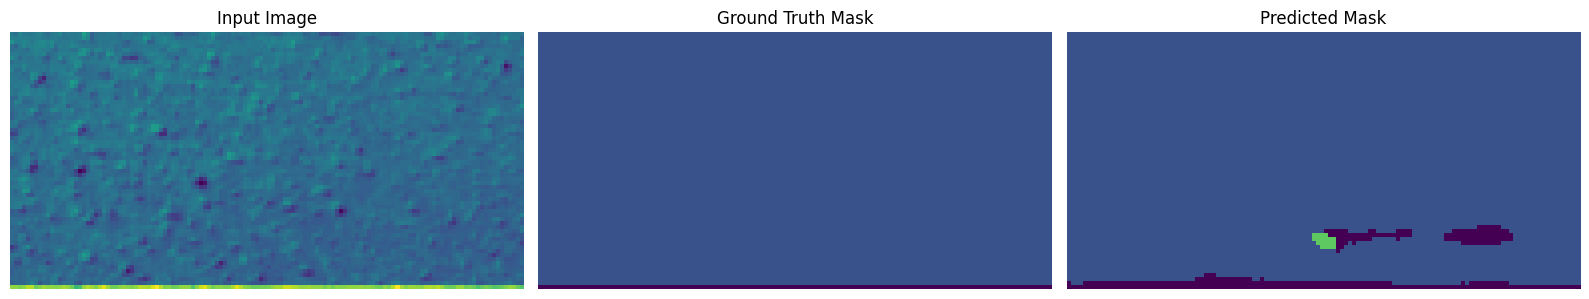

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9235 - loss: 0.2432 - mean_io_u: 0.6373 - val_accuracy: 0.5387 - val_loss: 2.9417 - val_mean_io_u: 0.2375
Epoch 92/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9698 - loss: 0.1124 - mean_io_u: 0.7231 - val_accuracy: 0.7384 - val_loss: 1.0561 - val_mean_io_u: 0.4311
Epoch 93/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9821 - loss: 0.0783 - mean_io_u: 0.7553 - val_accuracy: 0.7473 - val_loss: 1.0709 - val_mean_io_u: 0.4552
Epoch 94/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9868 - loss: 0.0649 - mean_io_u: 0.7681 - val_accuracy: 0.7320 - val_loss: 1.2387 - val_mean_io_u: 0.4535
Epoch 95/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9876 - loss: 0.0622 - mean_io_u: 0.7580 - val_accuracy: 0.7468 - val_loss: 1.1843 - val_mean_io_u: 0.4517
Epoch 96/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9872 - loss: 0.0628 - mean_io_u: 0.7643

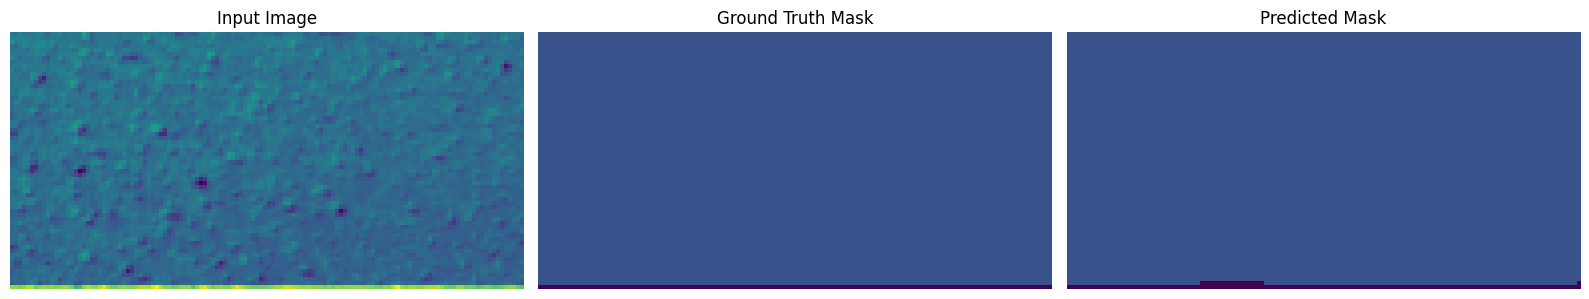

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9872 - loss: 0.0628 - mean_io_u: 0.7645 - val_accuracy: 0.7410 - val_loss: 1.2272 - val_mean_io_u: 0.4325
Epoch 97/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9864 - loss: 0.0648 - mean_io_u: 0.7629 - val_accuracy: 0.7250 - val_loss: 1.2448 - val_mean_io_u: 0.4137
Epoch 98/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9854 - loss: 0.0669 - mean_io_u: 0.7651 - val_accuracy: 0.7230 - val_loss: 1.3273 - val_mean_io_u: 0.4485
Epoch 99/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9854 - loss: 0.0666 - mean_io_u: 0.7644 - val_accuracy: 0.7320 - val_loss: 1.3509 - val_mean_io_u: 0.4652
Epoch 100/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9858 - loss: 0.0664 - mean_io_u: 0.7626 - val_accuracy: 0.7217 - val_loss: 1.4719 - val_mean_io_u: 0.4151
Epoch 101/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9853 - loss: 0.0671 - mean_io_u: 0.7711

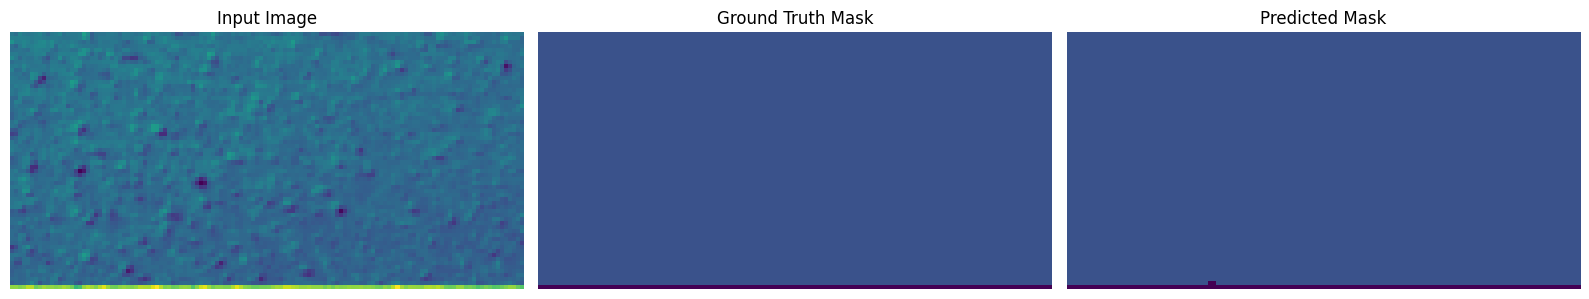

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9854 - loss: 0.0670 - mean_io_u: 0.7712 - val_accuracy: 0.7431 - val_loss: 1.2413 - val_mean_io_u: 0.4400
Epoch 102/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9858 - loss: 0.0655 - mean_io_u: 0.7681 - val_accuracy: 0.7352 - val_loss: 1.2150 - val_mean_io_u: 0.4297
Epoch 103/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9871 - loss: 0.0621 - mean_io_u: 0.7605 - val_accuracy: 0.7164 - val_loss: 1.3390 - val_mean_io_u: 0.4217
Epoch 104/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9878 - loss: 0.0605 - mean_io_u: 0.7731 - val_accuracy: 0.7345 - val_loss: 1.3001 - val_mean_io_u: 0.4451
Epoch 105/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9881 - loss: 0.0597 - mean_io_u: 0.7673 - val_accuracy: 0.7362 - val_loss: 1.3863 - val_mean_io_u: 0.4494
Epoch 106/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9877 - loss: 0.0602 - mean_io_u: 0.7674

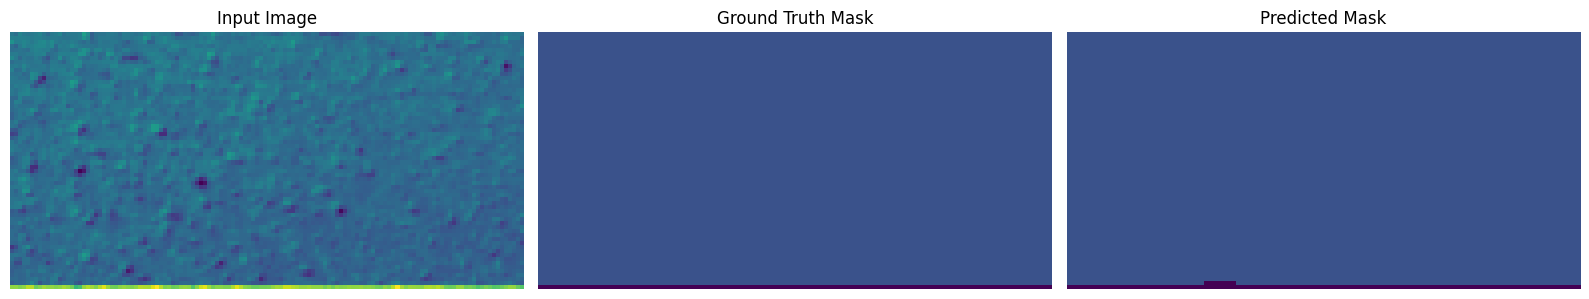

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9877 - loss: 0.0602 - mean_io_u: 0.7675 - val_accuracy: 0.7295 - val_loss: 1.3849 - val_mean_io_u: 0.4213
Epoch 107/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9876 - loss: 0.0606 - mean_io_u: 0.7598 - val_accuracy: 0.7243 - val_loss: 1.3893 - val_mean_io_u: 0.4316
Epoch 108/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9871 - loss: 0.0620 - mean_io_u: 0.7704 - val_accuracy: 0.7432 - val_loss: 1.2672 - val_mean_io_u: 0.4568
Epoch 109/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9869 - loss: 0.0627 - mean_io_u: 0.7640 - val_accuracy: 0.7359 - val_loss: 1.2602 - val_mean_io_u: 0.4280
Epoch 110/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9879 - loss: 0.0599 - mean_io_u: 0.7757 - val_accuracy: 0.7391 - val_loss: 1.2815 - val_mean_io_u: 0.4469
Epoch 111/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9887 - loss: 0.0579 - mean_io_u: 0.7719

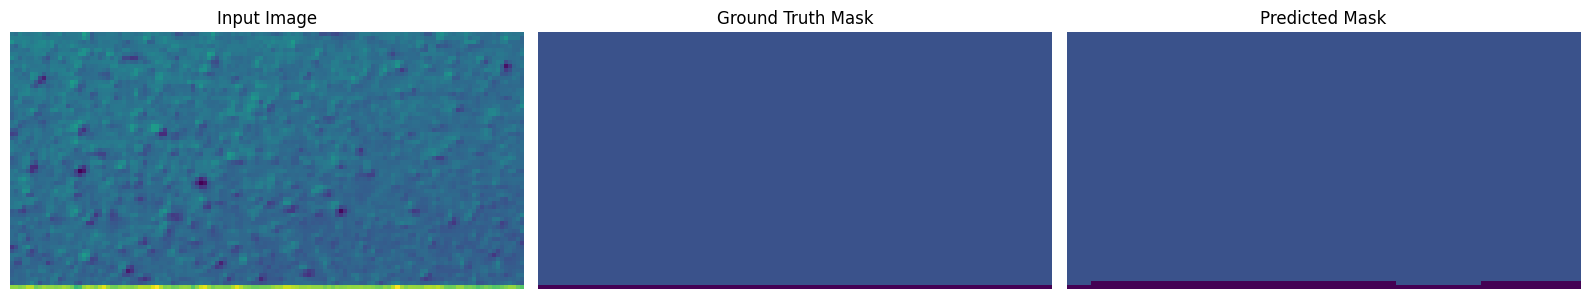

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9887 - loss: 0.0579 - mean_io_u: 0.7720 - val_accuracy: 0.6853 - val_loss: 1.6906 - val_mean_io_u: 0.3850
Epoch 112/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9833 - loss: 0.0760 - mean_io_u: 0.7606 - val_accuracy: 0.2571 - val_loss: 20.3666 - val_mean_io_u: 0.0137
Epoch 113/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8907 - loss: 0.3497 - mean_io_u: 0.5729 - val_accuracy: 0.5993 - val_loss: 1.8762 - val_mean_io_u: 0.2933
Epoch 114/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9658 - loss: 0.1240 - mean_io_u: 0.7217 - val_accuracy: 0.7334 - val_loss: 1.2020 - val_mean_io_u: 0.4263
Epoch 115/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9838 - loss: 0.0731 - mean_io_u: 0.7600 - val_accuracy: 0.7371 - val_loss: 1.1923 - val_mean_io_u: 0.4375
Epoch 116/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9890 - loss: 0.0588 - mean_io_u: 0.7632

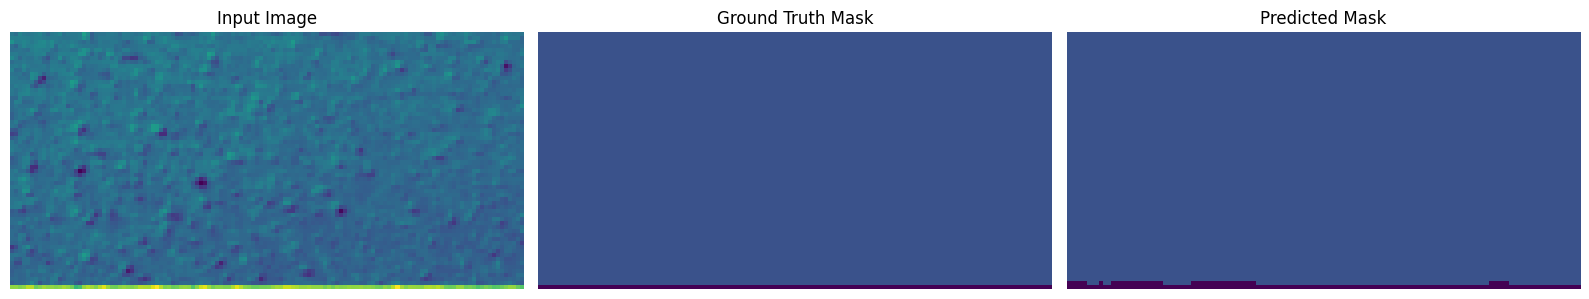

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9890 - loss: 0.0588 - mean_io_u: 0.7634 - val_accuracy: 0.7469 - val_loss: 1.2066 - val_mean_io_u: 0.4537
Epoch 117/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9909 - loss: 0.0540 - mean_io_u: 0.7677 - val_accuracy: 0.7424 - val_loss: 1.2611 - val_mean_io_u: 0.4503
Epoch 118/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9915 - loss: 0.0525 - mean_io_u: 0.7735 - val_accuracy: 0.7444 - val_loss: 1.2791 - val_mean_io_u: 0.4452
Epoch 119/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9909 - loss: 0.0530 - mean_io_u: 0.7787 - val_accuracy: 0.7364 - val_loss: 1.3101 - val_mean_io_u: 0.4427
Epoch 120/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9901 - loss: 0.0549 - mean_io_u: 0.7714 - val_accuracy: 0.7378 - val_loss: 1.3157 - val_mean_io_u: 0.4497
Epoch 121/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9890 - loss: 0.0574 - mean_io_u: 0.7766

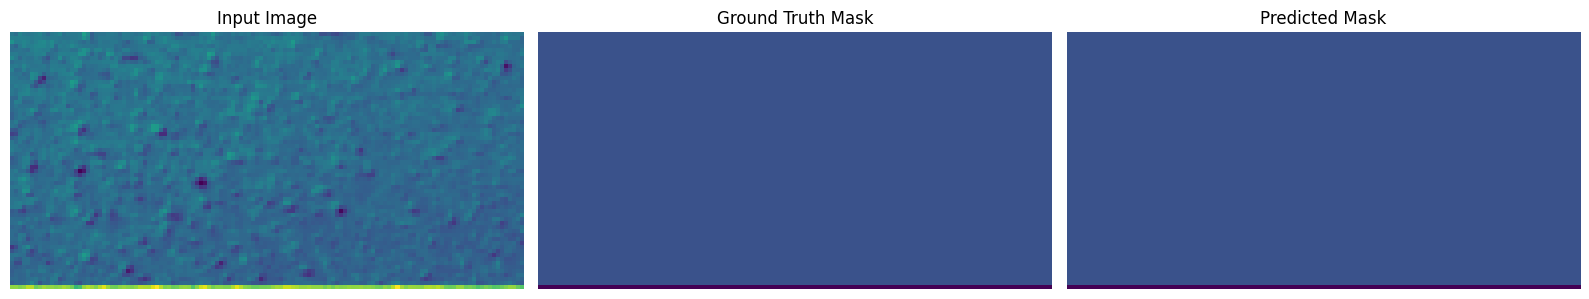

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9890 - loss: 0.0574 - mean_io_u: 0.7766 - val_accuracy: 0.7255 - val_loss: 1.4397 - val_mean_io_u: 0.4198
Epoch 122/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9877 - loss: 0.0603 - mean_io_u: 0.7749 - val_accuracy: 0.7337 - val_loss: 1.4509 - val_mean_io_u: 0.4475
Epoch 123/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9873 - loss: 0.0614 - mean_io_u: 0.7588 - val_accuracy: 0.7401 - val_loss: 1.3374 - val_mean_io_u: 0.4382
Epoch 124/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9879 - loss: 0.0603 - mean_io_u: 0.7622 - val_accuracy: 0.6903 - val_loss: 1.4836 - val_mean_io_u: 0.3828
Epoch 125/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9884 - loss: 0.0589 - mean_io_u: 0.7729 - val_accuracy: 0.7270 - val_loss: 1.2818 - val_mean_io_u: 0.4309
Epoch 126/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9889 - loss: 0.0574 - mean_io_u: 0.7724

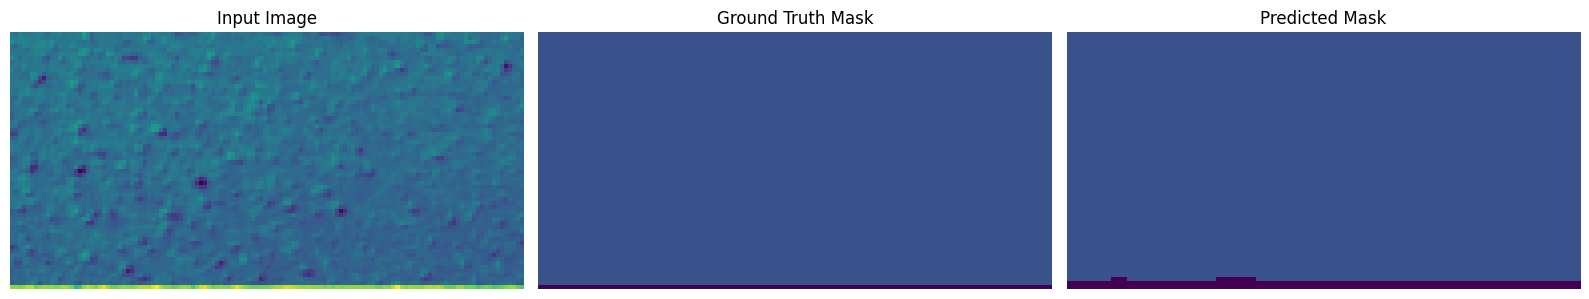

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9889 - loss: 0.0574 - mean_io_u: 0.7724 - val_accuracy: 0.7317 - val_loss: 1.4172 - val_mean_io_u: 0.4512
Epoch 127/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9893 - loss: 0.0565 - mean_io_u: 0.7801 - val_accuracy: 0.7182 - val_loss: 1.4854 - val_mean_io_u: 0.4209
Epoch 128/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9899 - loss: 0.0551 - mean_io_u: 0.7665 - val_accuracy: 0.7376 - val_loss: 1.3530 - val_mean_io_u: 0.4330
Epoch 129/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9906 - loss: 0.0531 - mean_io_u: 0.7709 - val_accuracy: 0.7406 - val_loss: 1.2706 - val_mean_io_u: 0.4412
Final validation Mean Intersection Over Union: 46.52%


In [22]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

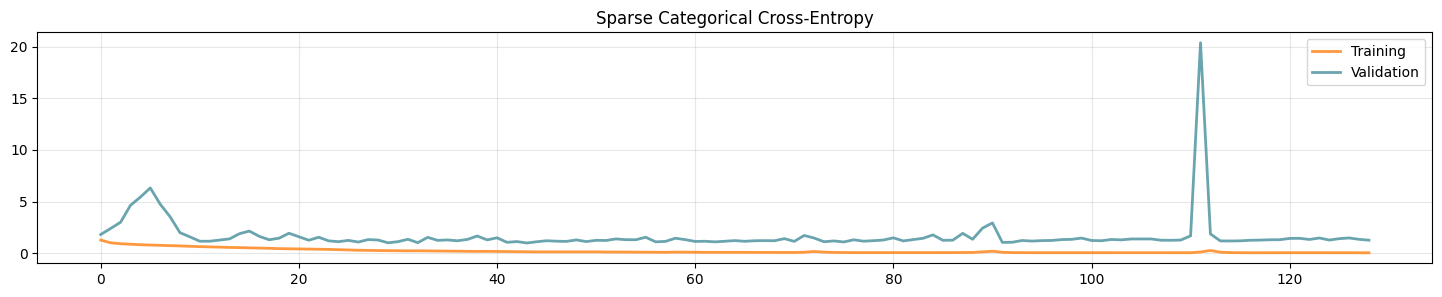

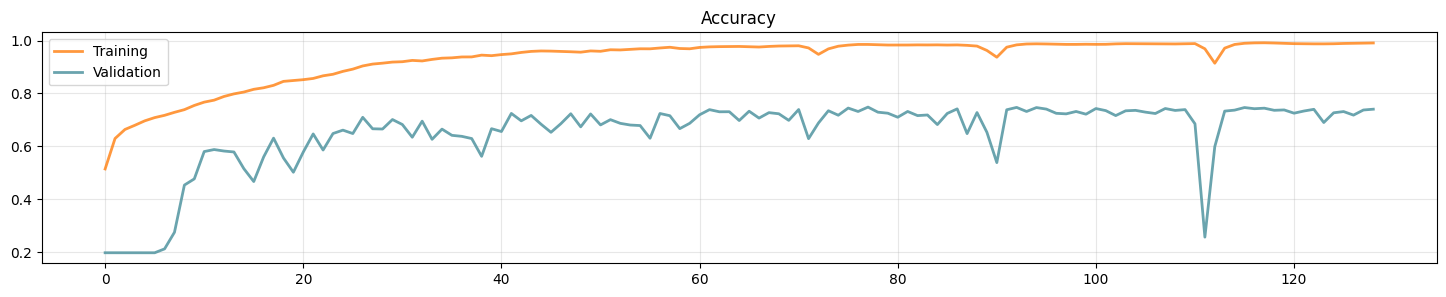

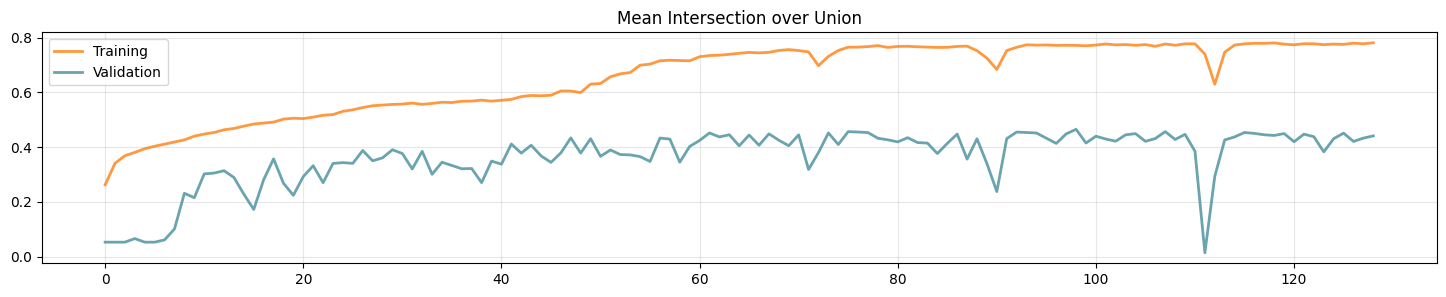

In [23]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Sparse Categorical Cross-Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241130_123505.keras


## 🕹️ Use the Model - Make Inference

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [25]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [26]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241130_123505.keras


In [27]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [28]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
Predictions shape: (10022, 64, 128)


In [29]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [30]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)